# Transaction Fraud Detectation Project -- Feature Engineering

The 'card transactions.csv' is a very big dataset, if I try to conduct every process all in one Jupyter Notebook, it will cause my kernel to die. So I separate the steps into several notebooks and deal with the process one by one. And this notebook is for feature engineering.


## Short Summary of Data Quality

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import calendar
import time
plt.style.use('ggplot')
start_time = dt.datetime.now()
%matplotlib inline
np.set_printoptions(suppress = True)

In [172]:
%%time
data = pd.read_csv('card transactions.csv')
data = data.iloc[:,0:10] # delete empty cols
data.shape

CPU times: user 157 ms, sys: 44.9 ms, total: 202 ms
Wall time: 201 ms


(96753, 10)

In [173]:
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,5142190439,1/1/10,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
1,2,5142183973,1/1/10,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0
2,3,5142131721,1/1/10,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0
3,4,5142148452,1/1/10,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0
4,5,5142190439,1/1/10,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0


In [174]:
numerics = ['Date','Amount']
categoricals = ['Recnum','Cardnum','Merchnum','Merch description',
               'Merch state','Merch zip','Transtype','Fraud']

In [175]:
categorical_data = data.loc[:,categoricals]
populated2 = categorical_data.notna().mean()
blank = categorical_data.isnull()
zeros = categorical_data[categoricals] == '0' 
# 0 in text, not include dummy numeric 0 in field 'Fraud' 
# 0 in field 'Fraud' has its meaning so it's good to exclude it here
unique = categorical_data.nunique(axis = 0)
mode = categorical_data.mode().iloc[0,:]
cate_summary = pd.DataFrame(data = {'% Populated':(populated2*100).round(2),
                                    '# Blank': blank.sum(),
                                    '# Zeros': zeros.sum(),
                                    '# Unique Values':unique.round(2),
                                    'Most Common Value':mode})
cate_summary

,% Populated,# Blank,# Zeros,# Unique Values,Most Common Value
Recnum,100.00,0,0,96753,1
Cardnum,100.00,0,0,1645,5142148452.0
Merchnum,96.51,3375,231,13091,930090121224
Merch description,100.00,0,0,13126,GSA-FSS-ADV
Merch state,98.76,1195,0,227,TN
Merch zip,95.19,4656,0,4567,38118.0
Transtype,100.00,0,0,4,P
Fraud,100.00,0,0,2,0.0


In [176]:
data['Date'] = pd.to_datetime(data['Date'])
numeric_data = data.loc[:,numerics]
populated2 = numeric_data.notna().mean()
blank = numeric_data.isnull()
zeros = numeric_data[numerics] == 0
mode =  numeric_data.mode().iloc[0,:]
num_summary = pd.DataFrame(data = {'% Populated':(populated2*100).round(2),
                                    '# Blank': blank.sum(),
                                    '# Zeros': zeros.sum(),
                                    'Most Common Value': mode,
                                    'Min': numeric_data[numerics].min(),
                                    'Max': numeric_data[numerics].max()})
num_summary

,% Populated,# Blank,# Zeros,Most Common Value,Min,Max
Date,100.0,0,0,2010-02-28 00:00:00,2010-01-01 00:00:00,2010-12-31 00:00:00
Amount,100.0,0,0,3.62,0.01,3102045.53


## Data Cleaning

### Filtering

In [177]:
data_copy = data.copy()
# We only need Transtype = 'P' (Purchase)
data_copy  = data_copy[data_copy['Transtype'] == 'P']

In [178]:
data_copy['Amount'].sort_values(ascending = False) # There is an outlier (index 52714) in amount, drop it
data_copy.shape

(96398, 10)

In [179]:
data_copy = data_copy.drop(index = 52714, axis = 0)
data_copy.shape

(96397, 10)

### Fill in Missing Data (Imputation)

In [180]:
# rename cols with space in it
data_copy.rename(columns={'Merch description': 'Merch_description', 
                          'Merch state': 'Merch_state',
                          'Merch zip': 'Merch_zip'}, inplace=True)

#### Merch state

In [181]:
empty_ms = data_copy[data_copy['Merch_state'].isna()]

##### Missing Merch state with zip code

In [182]:
# does the record have a zip code?
empty_ms_with_zp = empty_ms[empty_ms['Merch_zip'].notna()]
empty_ms_with_zp.Merch_zip.unique()

array([  926.,   929.,  1400., 65132., 86899., 23080., 60528.,   934.,
         902.,   738., 90805., 76302.,     9.,   914.,     6., 95461.,
       50823.,     2., 48700.,   680.,     1.,   681.,   623.,   726.,
         936., 12108.,   791.,   907.,   922.,   920.,     3.,   801.,
           8., 31040., 38117., 41160.])

In [183]:
# pip install uszipcode

In [184]:
# I use uszipcode package to find out the representative location of those zipcodes
from uszipcode import SearchEngine
engine = SearchEngine()

In [185]:
empty_ms_with_zp.index

Int64Index([ 3258,  3262,  3540,  3642,  4969,  5229,  5636,  5900,  6030,
             6136, 12152, 13558, 15019, 15124, 19330, 23374, 23490, 23620,
            24185, 24226, 24283, 24297, 25271, 25442, 25487, 26816, 26922,
            31712, 36538, 36789, 38034, 39023, 41267, 43466, 44407, 44563,
            46054, 47198, 50127, 51057, 51883, 52186, 56632, 56943, 57296,
            57661, 57794, 57981, 58138, 59094, 59270, 59479, 59582, 59825,
            59832, 59908, 60003, 60035, 60168, 60207, 60243, 60338, 60596,
            60901, 61417, 61430, 62420, 62657, 64882, 65084, 66157, 66182,
            66252, 69422, 70551, 70588, 72400, 72447, 73628, 74805, 77608,
            82782, 83272, 83425, 83454, 86405, 90259],
           dtype='int64')

Find out the representative location of each zip code. If we can match the zipcode to any location(state) in the US, fill the blank with that state. If the zipcode is not in the US, the function will report an error. Therefore, we use try-except here to avoid the error alarm and put those zip codes outside of the US into a list.

In [186]:
collect_outside_US = []
for i in empty_ms_with_zp.index:
    try:
        zipcode = engine.by_zipcode(data_copy.loc[i,'Merch_zip'].astype(int))
        data_copy.loc[i,'Merch_state'] = zipcode.state
    except AttributeError:
        collect_outside_US.append(i)
        print('{} is not in the USA.'.format(data_copy.loc[i,'Merch_zip']))
        pass

1400.0 is not in the USA.
65132.0 is not in the USA.
86899.0 is not in the USA.
23080.0 is not in the USA.
60528.0 is not in the USA.
60528.0 is not in the USA.
86899.0 is not in the USA.
60528.0 is not in the USA.
60528.0 is not in the USA.
23080.0 is not in the USA.
9.0 is not in the USA.
6.0 is not in the USA.
50823.0 is not in the USA.
6.0 is not in the USA.
2.0 is not in the USA.
48700.0 is not in the USA.
6.0 is not in the USA.
86899.0 is not in the USA.
48700.0 is not in the USA.
1.0 is not in the USA.
1.0 is not in the USA.
2.0 is not in the USA.
2.0 is not in the USA.
3.0 is not in the USA.
9.0 is not in the USA.
9.0 is not in the USA.
6.0 is not in the USA.
2.0 is not in the USA.
8.0 is not in the USA.
9.0 is not in the USA.
6.0 is not in the USA.


In [187]:
data_copy['Merch_state'].isna().sum()

964

##### Missing Merch state with zip code outside USA

In [188]:
# Because we know the location is outside the US
# We'll just fill in those missing values with 'Unknown'
for i in collect_outside_US:
    data_copy.loc[i,'Merch_state'] = 'Unknown'    

In [189]:
data_copy['Merch_state'].isna().sum()

933

##### Missing Merch state without zip code

In [190]:
# Using the Merch state of 'mode of Merch description' to replace all nan
mode = data_copy['Merch_description'].mode().tolist()[0]
state_mode = data_copy[data_copy['Merch_description'] == mode].iloc[0,5]
empty_after_fill_ms = data_copy[data_copy['Merch_state'].isna()]
for i in empty_after_fill_ms.index:
    data_copy.loc[i,'Merch_state'] = state_mode

In [191]:
data_copy['Merch_state'].isna().sum()

0

#### Merchnum

In [192]:
# if Merchnum = '0', replace with NaN
data_copy[data_copy['Merchnum'] == '0'] == True
data_copy['Merchnum'].replace('0',np.nan,inplace=True)
# test whether it change '0' into np.nan
print('#NaN in Merchnum: {}'\
      .format(data_copy['Merchnum'].isna().sum()))

#NaN in Merchnum: 3251


In [193]:
# We have no clear clue for deciding the Merchant number, 
# so we will use the Merchnum of 'mode of Merch description' to replace all nan
mode = data_copy['Merch_description'].mode().tolist()[0]
num_mode = data_copy[data_copy['Merch_description'] == mode].iloc[0,3]
empty_after_fill_mn = data_copy[data_copy['Merchnum'].isna()]
for i in empty_after_fill_mn.index:
    data_copy.loc[i,'Merchnum'] = num_mode

In [194]:
data_copy['Merchnum'].isna().sum()

0

#### Merch zip

In [195]:
# We will use the Merch zip of 'mode of Merch description' to replace all nan
mode = data_copy['Merch_description'].mode().tolist()[0]
zip_mode = data_copy[data_copy['Merch_description'] == mode].iloc[0,6]
empty_after_fill_mz = data_copy[data_copy['Merch_zip'].isna()]
for i in empty_after_fill_mz.index:
    data_copy.loc[i,'Merch_zip'] = zip_mode

In [196]:
data_copy['Merch_zip'].isna().sum()

0

In [197]:
data_copy.isna().sum()

Recnum               0
Cardnum              0
Date                 0
Merchnum             0
Merch_description    0
Merch_state          0
Merch_zip            0
Transtype            0
Amount               0
Fraud                0
dtype: int64

In [198]:
# keep a copy of the cleaned data just in case
data_copy.to_csv('cleaned_data.csv',index = False)

## Make Variables

In [10]:
data = pd.read_csv('cleaned_data.csv')

In [22]:
# Data Preparation
# Convert date
data['Date'] = pd.to_datetime(data['Date'])
# Make data from categorical field to be strings
data['Cardnum'] = data['Cardnum'].astype(str)
data['Merchnum'] = data['Merchnum'].astype(str)
data['Merch_description'] = data['Merch_description'].astype(str)
data['Merch_state'] = data['Merch_state'].astype(str)
data['Merch_zip'] = data['Merch_zip'].astype(str)
#right alignment
data['Cardnum']=data['Cardnum'].apply(lambda x:'{0:0>10}'.format(x))
data['Merch_zip']=data['Merch_zip'].apply(lambda x:'{0:0>5}'.format(x))
data['Merchnum']=data['Merchnum'].apply(lambda x:'{0:0>13}'.format(x))

data.dtypes

Recnum                        int64
Cardnum                      object
Date                 datetime64[ns]
Merchnum                     object
Merch_description            object
Merch_state                  object
Merch_zip                    object
Transtype                    object
Amount                      float64
Fraud                         int64
zip3                         object
dtype: object

Notification:<br>
I added 'zip3' as a new attribute after I ran everything in this notebook. It took hours to run it, and easy to cause my kernel to die. So for each feature generation cell, I have a code to save all the generated features in a CSV file right after they are created. Therefore, I just need to run the code for 'zip3' only. So the output in the notebook for now is for 'zip3' only. I'll show which codes need to be changed if I did include 'zip3' during the first run.

In [26]:
data['zip3'] = data['Merch_zip'].str.slice(2,5)
data.dtypes

Recnum                        int64
Cardnum                      object
Date                 datetime64[ns]
Merchnum                     object
Merch_description            object
Merch_state                  object
Merch_zip                    object
Transtype                    object
Amount                      float64
Fraud                         int64
zip3                         object
dtype: object

### Day of Week Target Encoding

In [201]:
data['dow'] = data.Date.apply(lambda x: calendar.day_name[x.weekday()])

In [202]:
# Separate the OOT
train_set = data[data.Date < '2010-11-01']

In [203]:
#Statistical Smoothing
c = 4;nmid = 20;y_avg = train_set['Fraud'].mean()
y_dow = train_set.groupby('dow')['Fraud'].mean()
num = train_set.groupby('dow').size()
y_dow_smooth = y_avg + (y_dow - y_avg)/(1 + np.exp(-(num - nmid)/c))
data['dow_risk'] = data.dow.map(y_dow_smooth)

In [204]:
# delete files that we don't need any more to free up memory
del train_set

In [205]:
y_dow = y_dow.reset_index()
cats = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
y_dow['dow'] = pd.Categorical(y_dow['dow'],categories = cats,ordered = True)
y_dow = y_dow.sort_values('dow')
y_dow = y_dow.set_index('dow')

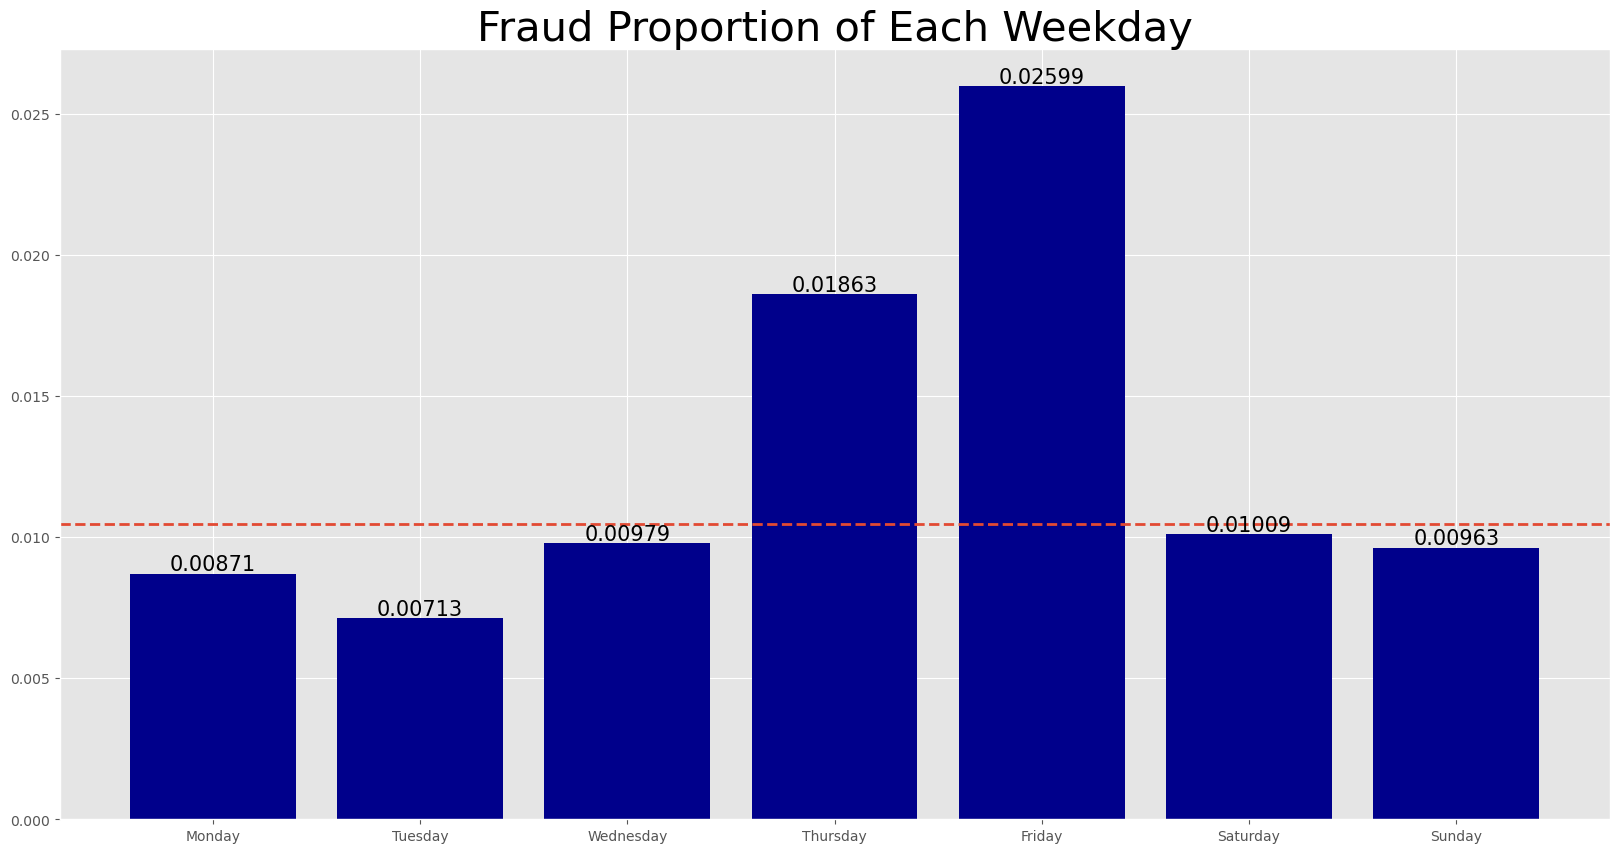

In [206]:
#plot
fig,ax = plt.subplots(figsize=(20,10))
plt.bar(data = y_dow,x = y_dow.index,height = 'Fraud',color = 'darkblue')
ax.axhline(y = y_avg,ls = '--',lw = 2)
plt.title('Fraud Proportion of Each Weekday', fontsize = 30)

for i in (y_dow.index):
    ax.text(i,y_dow.loc[i,'Fraud'] + 0.0001,round(y_dow.loc[i,'Fraud'],5),\
            horizontalalignment = 'center',fontsize = 15)

plt.savefig('risktable.png')
plt.show()

### Make new entities

In [207]:
data.dtypes

Recnum                        int64
Cardnum                      object
Date                 datetime64[ns]
Merchnum                     object
Merch_description            object
Merch_state                  object
Merch_zip                    object
Transtype                    object
Amount                      float64
Fraud                         int64
dow                          object
dow_risk                    float64
dtype: object

In [208]:
data['Merch_num_des'] = data.Merchnum + data.Merch_description
data['Merch_num_state'] = data.Merchnum + data.Merch_state
data['Merch_num_zip'] = data.Merchnum + data.Merch_zip
data['Merch_des_state'] = data.Merch_description + data.Merch_state
data['Merch_des_zip'] = data.Merch_description + data.Merch_zip
data['Merch_state_zip'] = data.Merch_state + data.Merch_zip
data['Merch_num_des_state'] = data.Merchnum + data.Merch_description + data.Merch_state
data['Merch_num_des_zip'] = data.Merchnum + data.Merch_description + data.Merch_zip
data['Merch_num_state_zip'] = data.Merchnum + data.Merch_state + data.Merch_zip
data['Merch_des_state_zip'] = data.Merch_description + data.Merch_state + data.Merch_zip
data['Merch_all_info'] = data.Merchnum + data.Merch_description + data.Merch_state + data.Merch_zip

In [209]:
data.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch_description',
       'Merch_state', 'Merch_zip', 'Transtype', 'Amount', 'Fraud', 'dow',
       'dow_risk', 'Merch_num_des', 'Merch_num_state', 'Merch_num_zip',
       'Merch_des_state', 'Merch_des_zip', 'Merch_state_zip',
       'Merch_num_des_state', 'Merch_num_des_zip', 'Merch_num_state_zip',
       'Merch_des_state_zip', 'Merch_all_info'],
      dtype='object')

In [210]:
# if I include zip3 at the first place, the list here should be: list(data.iloc[:,np.r_[3:7,10,13:24]])
for i in list(data.iloc[:,np.r_[3:7,12:23]]):
    data['Card_'+i] = data.Cardnum + data[i]

In [211]:
len(data.columns)

38

In [27]:
# the whole list of attributes should be:  list(data.iloc[:,np.r_[1, 3:7,10,13:39]].columns)
attributes= ['zip3']
attributes

['zip3']

In [241]:
len(attributes)

31

In [213]:
data.isna().sum()

Recnum                      0
Cardnum                     0
Date                        0
Merchnum                    0
Merch_description           0
Merch_state                 0
Merch_zip                   0
Transtype                   0
Amount                      0
Fraud                       0
dow                         0
dow_risk                    0
Merch_num_des               0
Merch_num_state             0
Merch_num_zip               0
Merch_des_state             0
Merch_des_zip               0
Merch_state_zip             0
Merch_num_des_state         0
Merch_num_des_zip           0
Merch_num_state_zip         0
Merch_des_state_zip         0
Merch_all_info              0
Card_Merchnum               0
Card_Merch_description      0
Card_Merch_state            0
Card_Merch_zip              0
Card_Merch_num_des          0
Card_Merch_num_state        0
Card_Merch_num_zip          0
Card_Merch_des_state        0
Card_Merch_des_zip          0
Card_Merch_state_zip        0
Card_Merch

### New Variables

#### Benford's Law

In [44]:
bf = data.copy()
bf['amount_100'] = (bf['Amount']*100).astype(str)
bf['first_dig'] = bf['amount_100'].str[0]
dropfedex = bf[bf['Merch_description'].str.contains('FEDEX')]
droplist = dropfedex.index.tolist()
bf1 = bf.drop(droplist)
bf1['bin'] = bf1['first_dig'].apply(lambda x:'low' if x == '1'\
                                   else ('low' if x == '2' else 'high'))

In [45]:
card_bf = bf1.groupby(['Cardnum','bin']).agg({'bin':['count']}).reset_index()
card_bf.columns = ['Cardnum','bin','count']

In [46]:
card_bf = card_bf.pivot_table(index = 'Cardnum', columns = 'bin',
                             values = 'count', aggfunc = 'sum').reset_index()
card_bf.columns = ['Cardnum','n_high','n_low']
card_bf = card_bf.fillna(1) 
card_bf

,Cardnum,n_high,n_low
0,5142110002,1.0,1.0
1,5142110081,4.0,1.0
2,5142110313,1.0,2.0
3,5142110402,8.0,3.0
4,5142110434,1.0,1.0
...,...,...,...
1635,5142310397,1.0,1.0
1636,5142310525,3.0,1.0
1637,5142310598,1.0,2.0
1638,5142310768,2.0,2.0


In [47]:
# calculating R, 1/R, U, n, t, U_smoothed
c = 3
n_mid = 15
card_bf['R'] = (1.096 * card_bf['n_low']/card_bf['n_high'])
card_bf['1/R'] = (1/card_bf['R'])
card_bf['U'] = list(map(lambda x,y:max(x,y),card_bf['R'],card_bf['1/R']))
card_bf['n'] = card_bf['n_high'] + card_bf['n_low']
card_bf['t'] = ((card_bf['n'] - n_mid)/c)
card_bf['U_smoothed'] = list(map(lambda x,y:(1+(x-1)/(1+np.exp(-y))),card_bf['U'],card_bf['t']))
card_bf['U_smoothed'] = card_bf['U_smoothed']

In [48]:
merch_bf = bf1.groupby(['Merchnum','bin']).agg({'bin':['count']}).reset_index()
merch_bf.columns = ['Merchnum','bin','count']
merch_bf = merch_bf.pivot_table(index = 'Merchnum', columns = 'bin',
                             values = 'count', aggfunc = 'sum').reset_index()
merch_bf.columns = ['Merchnum','n_high','n_low']
merch_bf = merch_bf.fillna(1) 
merch_bf

,Merchnum,n_high,n_low
0,0000000000499,1.0,1.0
1,0000000001408,1.0,1.0
2,0000000004227,1.0,1.0
3,0000000006763,4.0,1.0
4,0000000006929,9.0,3.0
...,...,...,...
13077,9995659070006,1.0,1.0
13078,9996060597900,1.0,1.0
13079,DU49038320006,1.0,1.0
13080,PENNE9 CO #05,1.0,1.0


In [49]:
# calculating R, 1/R, U, n, t, U_smoothed
c = 3
n_mid = 15
merch_bf['R'] = (1.096 * merch_bf['n_low']/merch_bf['n_high'])
merch_bf['1/R'] = (1/merch_bf['R'])
merch_bf['U'] = list(map(lambda x,y:max(x,y),merch_bf['R'],merch_bf['1/R']))
merch_bf['n'] = merch_bf['n_high'] + merch_bf['n_low']
merch_bf['t'] = ((merch_bf['n'] - n_mid)/c)
merch_bf['U_smoothed'] = list(map(lambda x,y:(1+(x-1)/(1+np.exp(-y))),merch_bf['U'],merch_bf['t']))
merch_bf['U_smoothed'] = merch_bf['U_smoothed']

In [50]:
card_bf.set_index('Cardnum', inplace = True)
card_Ustar = pd.DataFrame(card_bf['U_smoothed'])
card_Ustar.sort_values(['U_smoothed'],ascending = False).head(3)

,U_smoothed
Cardnum,
5142253356,13.371199
5142299705,9.027976
5142197563,8.150852


In [51]:
merch_bf.set_index('Merchnum', inplace = True)
merch_Ustar = pd.DataFrame(merch_bf['U_smoothed'])
merch_Ustar.sort_values(['U_smoothed'],ascending = False).head(3)

,U_smoothed
Merchnum,
0991808369338,165.145985
8078200641472,64.663981
0308904389335,48.357557


In [94]:
final = data.copy() 
final = final.merge(card_Ustar, how = 'left', left_on = 'Cardnum',
                    right_on = card_Ustar.index)
final = final.rename(columns = {'U_smoothed': 'U_smoothed_cardnum'})
final = final.merge(merch_Ustar, how = 'left', left_on = 'Merchnum',
                    right_on = merch_Ustar.index)
final = final.rename(columns = {'U_smoothed': 'U_smoothed_merchnum'})
final['U_smoothed_cardnum'] = final['U_smoothed_cardnum'].replace(np.nan,1)
final['U_smoothed_merchnum'] = final['U_smoothed_merchnum'].replace(np.nan,1)

final.to_csv('3_3_1_bf_law.csv')

#### Preparation for further variable making

In [29]:
# Because my computational power is not enough for running the whole notebook
# Here we seperate the datasets to run it one by one
def writing_csv(dataframe, filename):
    try:
        dataframe.to_csv('output/' + filename + '.csv',index=False)
    except:
        dataframe.to_csv(filename + '.csv',index=False)

In [30]:
numvar = {}
listvar = []

def num_column_count(dataframe, name):
    
    global numvar, listvar
    
    numvars_new = len(dataframe.columns) - 2 # Exclude Recnum and Fraud 
    numvar[name] = numvars_new
    
    listvar_new = dataframe.columns.to_list()[2:] # Exclude Recnum and Fraud 
    listvar += listvar_new

    print("from Dataframe: " + name)
    print("new variables:", numvars_new,"  total variables:", sum(numvar.values()))

In [31]:
df = data.copy()
df['check_Date'] = df.Date
df['check_Recnum'] = df.Recnum

In [32]:
# Use this instead of "vars"
# Only keep "Recnum" and "Fraud". Thus, each of my csv file will not have any variables mixing together.
fraud_label = data.loc[:, ["Recnum", "Fraud"]].copy() 
print(fraud_label.shape)
fraud_label.head()

(96397, 2)


,Recnum,Fraud
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


#### Day Since & Velocity

In [33]:
%%time
begin=time.time()

vars_3_3_3= fraud_label.copy() 

for i in attributes:
    st = time.time()
    df_1 = df[['Recnum','Date',i]]
    df_r = df[['check_Recnum','check_Date',i,'Amount']]
    temp = pd.merge(df_1, df_r, left_on = i, right_on = i)
    
    # day since
    day_since_df = temp[temp.Recnum > temp.check_Recnum][['Recnum','Date','check_Date']]\
        .groupby('Recnum')[['Date','check_Date']].last()
    mapper = (day_since_df.Date-day_since_df.check_Date).dt.days
    vars_3_3_3[i + '_day_since'] = vars_3_3_3.Recnum.map(mapper)
    vars_3_3_3[i + '_day_since'].fillna(365, inplace = True)
    print(f'\n{i}_day_since --->Done')
    
    # Velocity
    for t in [0,1,3,7,14,30]:
        temp2 = temp[(temp.check_Date >= (temp.Date - dt.timedelta(t)))& 
                     (temp.Recnum >= temp.check_Recnum)]   
        mapper2 = temp2.groupby('Recnum')[i].count()
        vars_3_3_3[i + '_count_' +str(t)] = vars_3_3_3.Recnum.map(mapper2)
        print(f'{i}_count_{str(t)} --->Done')   
        
    del df_1, df_r, temp
    vars_3_3_3 = vars_3_3_3.copy() # solve for fragmented DataFrame

    print(f'Run time for entity {i}--------{time.time()-st:0.2f}s')

writing_csv(vars_3_3_3, '3_3_3_zip3_velocity_counts_and_days_since')
num_column_count(vars_3_3_3, '3_3_3_zip3_velocity_counts_and_days_since')
# For the previous run (with all the other attributes except zip3) the csv name is '3_3_3_velocity_counts_and_days_since'
# The following naming of CSV files for saving feature purposes follows the same way
print(f'Total run time:{(time.time()-begin)/60:0.2f}min')


zip3_day_since --->Done
zip3_count_0 --->Done
zip3_count_1 --->Done
zip3_count_3 --->Done
zip3_count_7 --->Done
zip3_count_14 --->Done
zip3_count_30 --->Done
Run time for entity zip3--------328.29s
from Dataframe: 3_3_3_zip3_velocity_counts_and_days_since
new variables: 7   total variables: 7
Total run time:5.48min
CPU times: user 1min 15s, sys: 3min 31s, total: 4min 47s
Wall time: 5min 28s


#### Amount Variables

In [34]:
%%time
begin=time.time()

vars_3_3_4 = data.loc[:, ['Recnum', 'Fraud','Amount']].copy()  # we need 'Amount' here

for i in attributes:
    df_1 = df[['Recnum','Date',i]]
    df_r = df[['check_Recnum','check_Date',i,'Amount']]
    temp = pd.merge(df_1, df_r, left_on = i, right_on = i)
    for t in [0,1,3,7,14,30]:
        temp2 = temp[(temp.check_Date >= (temp.Date - dt.timedelta(t))) &\
                     (temp.Recnum >= temp.check_Recnum)][['Recnum',i, 'Amount']]       
        vars_3_3_4[i + '_avg_' + str(t)] = vars_3_3_4.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
        vars_3_3_4[i + '_max_' + str(t)] = vars_3_3_4.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
        vars_3_3_4[i + '_med_' + str(t)] = vars_3_3_4.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
        vars_3_3_4[i + '_total_' + str(t)] = vars_3_3_4.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
        vars_3_3_4[i + '_actual/avg_' + str(t)] = vars_3_3_4['Amount'] / vars_3_3_4[i + '_avg_' + str(t)]
        vars_3_3_4[i + '_actual/max_' + str(t)] = vars_3_3_4['Amount'] / vars_3_3_4[i + '_max_' + str(t)]
        vars_3_3_4[i + '_actual/med_' + str(t)] = vars_3_3_4['Amount'] / vars_3_3_4[i + '_med_' + str(t)]
        vars_3_3_4[i + '_actual/toal_' + str(t)] = vars_3_3_4['Amount'] / vars_3_3_4[i + '_total_' + str(t)]       
        print(i + ' amount variables over past ' + str(t) + ' ---> Done')

writing_csv(vars_3_3_4, '3_3_4_zip3_amount_var')
num_column_count(vars_3_3_4, '3_3_4_zip3_amount_var')

print(f'Total run time:{(time.time()-begin)/60:0.2f}min')
        

zip3 amount variables over past 0 ---> Done
zip3 amount variables over past 1 ---> Done
zip3 amount variables over past 3 ---> Done
zip3 amount variables over past 7 ---> Done
zip3 amount variables over past 14 ---> Done
zip3 amount variables over past 30 ---> Done
from Dataframe: 3_3_4_zip3_amount_var
new variables: 49   total variables: 56
Total run time:4.69min
CPU times: user 1min 9s, sys: 2min 59s, total: 4min 8s
Wall time: 4min 41s


####  Relative Velocity & Velocity days since ratio

In [35]:
%%time

begin=time.time()

vars_3_3_5 = fraud_label.copy()

for i in attributes:
    for d in ['0','1']:
        for dd in ['7','14','30']:
            vars_3_3_5[i+'_count_'+d+'_by_'+dd] = \
            vars_3_3_3[i+'_count_'+d]/(vars_3_3_3[i+'_count_'+dd]/float(dd))
            vars_3_3_5[i+'_vdratio'+d+'_day_since'] =\
            vars_3_3_5[i+'_count_'+d+'_by_'+dd]/(vars_3_3_3[i+'_day_since']+1)
            
    vars_3_3_5 = vars_3_3_5.copy()
                                          
writing_csv(vars_3_3_5, '3_3_5_zip3_relative&daysince_vel')
num_column_count(vars_3_3_5, '3_3_5_zip3_relative&daysince_vel')

print(f'Total run time:{time.time()-begin:0.2f}s')

from Dataframe: 3_3_5_zip3_relative&daysince_vel
new variables: 8   total variables: 64
Total run time:0.88s
CPU times: user 805 ms, sys: 54.2 ms, total: 860 ms
Wall time: 881 ms


#### Variability

In [36]:
%%time
begin = time.time()

vars_3_3_7 = fraud_label.copy()

for i in attributes:
    st = time.time()
    df_l = df[['Recnum', 'Date', i,'Amount']]
    df_r = df[['check_Recnum', 'check_Date', i, 'Amount']]
    temp = pd.merge(df_l, df_r, left_on = i, right_on = i)
    
    for t in [0,1,3,7,14,30]:
        temp3 = temp[(temp.check_Date >= (temp.Date - dt.timedelta(t))) &\
                       (temp.Recnum >= temp.check_Recnum)][['Recnum', 'check_Recnum',i, 'Amount_x','Amount_y']]
        temp3['Amount_diff']=temp3['Amount_y']-temp3['Amount_x']
        
        mapper3 = temp3.groupby('Recnum')['Amount_diff'].agg(['mean','max','median'])
        mapper3 = mapper3.rename(columns = {'mean':'avg','max':'max','median':'med'})
        mapper3 = mapper3.rename(columns = lambda text: i+'_variability_'+ text + str(t)) 
        vars_3_3_7 = vars_3_3_7.merge(mapper3, left_on = 'Recnum',right_on = 'Recnum')
        
        
        
#         col_name = i + '_variability_avg_' + str(t)
#         mapper3 = temp3.groupby('Recnum')['Amount_diff'].mean()
#         vars_3_3_7[col_name] = vars_3_3_7.Recnum.map(mapper3)        
#         print(col_name + ' ---> Done')
        
#         col_name = i + '_variability_max_' + str(t)
#         mapper3 = temp3.groupby('Recnum')['Amount_diff'].max()
#         vars_3_3_7[col_name] = vars_3_3_7.Recnum.map(mapper3)        
#         print(col_name + ' ---> Done')
        
#         col_name = i + '_variability_med_' + str(t)
#         mapper3 = temp3.groupby('Recnum')['Amount_diff'].median()
#         vars_3_3_7[col_name] = vars_3_3_7.Recnum.map(mapper3)        
#         print(col_name + ' ---> Done')
        
        print( f'Run time for amount variables {i}--------{time.time()-st:0.2f}s---> Done')

writing_csv(vars_3_3_7, '3_3_7_zip3_variability')
num_column_count(vars_3_3_7, '3_3_7_zip3_variability')

print(f'Total run time:{time.time()-begin:0.2f}s')

del vars_3_3_7   
       

Run time for amount variables zip3--------154.58s---> Done
Run time for amount variables zip3--------186.72s---> Done
Run time for amount variables zip3--------215.94s---> Done
Run time for amount variables zip3--------250.88s---> Done
Run time for amount variables zip3--------284.40s---> Done
Run time for amount variables zip3--------327.62s---> Done
from Dataframe: 3_3_7_zip3_variability
new variables: 18   total variables: 82
Total run time:329.31s
CPU times: user 1min 11s, sys: 3min 24s, total: 4min 36s
Wall time: 5min 29s


#### Cross entity uniqueness variables

In [92]:
# My original attributes is too large for my laptop to run
# And I found that some attributes are not that useful tbh
# So I subset it for cross entity uniqueness variables
from operator import itemgetter
attributes_2 = list(itemgetter(0,1,2,5,15)(attributes))
for i in attributes[16:]:
    attributes_2.append(i)
attributes_2

['Cardnum',
 'Merchnum',
 'Merch_description',
 'Merch_num_des',
 'Merch_all_info',
 'Card_Merchnum',
 'Card_Merch_description',
 'Card_Merch_state',
 'Card_Merch_zip',
 'Card_Merch_num_des',
 'Card_Merch_num_state',
 'Card_Merch_num_zip',
 'Card_Merch_des_state',
 'Card_Merch_des_zip',
 'Card_Merch_state_zip',
 'Card_Merch_num_des_state',
 'Card_Merch_num_des_zip',
 'Card_Merch_num_state_zip',
 'Card_Merch_des_state_zip',
 'Card_Merch_all_info']

In [93]:
%%time
begin=time.time()

count_attributes = 0 # For naming only

for i in attributes_2:
    
    count_attributes += 1
    vars_3_3_8_i = fraud_label.copy() 
    
    for v in attributes_2:
        st=time.time()
        if i==v:
            continue
        else:
            df_c=df[['Recnum','Date',i]]
            df_d=df[['check_Recnum','check_Date',i,v]]
            temp=pd.merge(df_c,df_d,left_on=i,right_on=i)
        
        #number of unique for particular field
        for t in[0,1,3,7,14,30]:
            count_day_df = temp[((temp.check_Date)>=(temp.Date-dt.timedelta(t)))
                          &(temp.Recnum>=temp.check_Recnum)]
            col_name = f'{i}_unique_count_for_{v}_{t}'
            mapper = count_day_df.groupby(['Recnum'])[v].nunique()
            vars_3_3_8_i[col_name] = vars_3_3_8_i.Recnum.map(mapper)
        
        print(f'Run time for entity {i} in field {v}--------{time.time()-st:0.2f}s')

        del df_c, df_d, temp
        
        vars_3_3_8_i = vars_3_3_8_i.copy() # solve for fragmented DataFrame
    
    dataframe_name = '3_3_8_counts_entities_' + '{0:0>2}'.format(count_attributes) + '_' + i 
    writing_csv(vars_3_3_8_i, dataframe_name)
    num_column_count(vars_3_3_8_i, dataframe_name)
    del vars_3_3_8_i

    print(f'Total run time:{(time.time()-begin)/60:0.2f}min')
        

Run time for entity Cardnum in field Merchnum--------17.78s
Run time for entity Cardnum in field Merch_description--------7.06s
Run time for entity Cardnum in field Merch_num_des--------6.72s
Run time for entity Cardnum in field Merch_all_info--------6.69s
Run time for entity Cardnum in field Card_Merchnum--------6.29s
Run time for entity Cardnum in field Card_Merch_description--------6.55s
Run time for entity Cardnum in field Card_Merch_state--------6.31s
Run time for entity Cardnum in field Card_Merch_zip--------5.75s
Run time for entity Cardnum in field Card_Merch_num_des--------6.01s
Run time for entity Cardnum in field Card_Merch_num_state--------5.90s
Run time for entity Cardnum in field Card_Merch_num_zip--------5.81s
Run time for entity Cardnum in field Card_Merch_des_state--------5.94s
Run time for entity Cardnum in field Card_Merch_des_zip--------5.98s
Run time for entity Cardnum in field Card_Merch_state_zip--------5.83s
Run time for entity Cardnum in field Card_Merch_num_de

Run time for entity Card_Merchnum in field Card_Merch_num_des--------1.42s
Run time for entity Card_Merchnum in field Card_Merch_num_state--------1.33s
Run time for entity Card_Merchnum in field Card_Merch_num_zip--------1.36s
Run time for entity Card_Merchnum in field Card_Merch_des_state--------1.47s
Run time for entity Card_Merchnum in field Card_Merch_des_zip--------1.43s
Run time for entity Card_Merchnum in field Card_Merch_state_zip--------1.37s
Run time for entity Card_Merchnum in field Card_Merch_num_des_state--------1.45s
Run time for entity Card_Merchnum in field Card_Merch_num_des_zip--------1.53s
Run time for entity Card_Merchnum in field Card_Merch_num_state_zip--------1.39s
Run time for entity Card_Merchnum in field Card_Merch_des_state_zip--------1.46s
Run time for entity Card_Merchnum in field Card_Merch_all_info--------1.51s
from Dataframe: 3_3_8_counts_entities_06_Card_Merchnum
new variables: 114   total variables: 684
Total run time:48.31min
Run time for entity Card_

Run time for entity Card_Merch_num_state in field Card_Merch_num_zip--------1.32s
Run time for entity Card_Merch_num_state in field Card_Merch_des_state--------1.40s
Run time for entity Card_Merch_num_state in field Card_Merch_des_zip--------1.42s
Run time for entity Card_Merch_num_state in field Card_Merch_state_zip--------1.37s
Run time for entity Card_Merch_num_state in field Card_Merch_num_des_state--------1.42s
Run time for entity Card_Merch_num_state in field Card_Merch_num_des_zip--------1.43s
Run time for entity Card_Merch_num_state in field Card_Merch_num_state_zip--------1.35s
Run time for entity Card_Merch_num_state in field Card_Merch_des_state_zip--------1.42s
Run time for entity Card_Merch_num_state in field Card_Merch_all_info--------1.44s
from Dataframe: 3_3_8_counts_entities_11_Card_Merch_num_state
new variables: 114   total variables: 1254
Total run time:50.79min
Run time for entity Card_Merch_num_zip in field Cardnum--------1.39s
Run time for entity Card_Merch_num_zi

Run time for entity Card_Merch_num_des_state in field Card_Merch_num_des--------0.67s
Run time for entity Card_Merch_num_des_state in field Card_Merch_num_state--------0.65s
Run time for entity Card_Merch_num_des_state in field Card_Merch_num_zip--------0.65s
Run time for entity Card_Merch_num_des_state in field Card_Merch_des_state--------0.66s
Run time for entity Card_Merch_num_des_state in field Card_Merch_des_zip--------0.67s
Run time for entity Card_Merch_num_des_state in field Card_Merch_state_zip--------0.65s
Run time for entity Card_Merch_num_des_state in field Card_Merch_num_des_zip--------0.70s
Run time for entity Card_Merch_num_des_state in field Card_Merch_num_state_zip--------0.67s
Run time for entity Card_Merch_num_des_state in field Card_Merch_des_state_zip--------0.68s
Run time for entity Card_Merch_num_des_state in field Card_Merch_all_info--------0.68s
from Dataframe: 3_3_8_counts_entities_16_Card_Merch_num_des_state
new variables: 114   total variables: 1824
Total ru

## Summary 

In [249]:
# The num_column_count function should count the number of variable for me
# But I ran my code while I wrote the notebook
# Unfortunately my kernel died many times so the record lost
# I commented my making_variable codes after I successfully generated the CSV file 
# So if the kernel died, I don't have to run them again because I got my CSV files containing all my variables
# I lose most of the tracing times because of the died kernel as well, but rerun them are too painful
# I'll just use my CSV files to do the summary and estimate the time I use

import glob

joined_files_3_ = glob.glob('output/3_3_*.csv')
count_var = []
sum_var = 0

for i in range(len(joined_files_3_)):
    dt = pd.read_csv(joined_files_3_[i])
    count_var.append(dt.shape[1]-2) # remove Recnum and Fraud
    sum_var += count_var[i]

In [253]:
sum_v = sum_var
sum_v = sum_v - (41-5)  
# 41 is the #col in '3_3_1_bf_law_dedup.csv'
# 5 is the #col that I need to keep in that csv file for further feature selection
print(sum_v)

4795


In [247]:
result = zip(joined_files_3_,count_var)
result = pd.DataFrame(result, columns = ['csv','count_var'])
result
# I forgot remove the attributes from my csv file, they are in '3_3_1_bf_law.csv'
# I removed those attributes in dedup

,csv,count_var
0,output/3_3_8_counts_entities_03_Merch_descript...,114
1,output/3_3_8_counts_entities_14_Card_Merch_des...,114
2,output/3_3_8_counts_entities_01_Cardnum.csv,114
3,output/3_3_8_counts_entities_07_Card_Merch_des...,114
4,output/3_3_8_counts_entities_17_Card_Merch_num...,114
5,output/3_3_7_variability.csv,558
6,output/3_3_8_counts_entities_08_Card_Merch_sta...,114
7,output/3_3_8_counts_entities_19_Card_Merch_des...,114
8,output/3_3_1_bf_law.csv,39
9,output/3_3_5_relative&daysince_vel.csv,248


In [ ]:
# I lose most of the tracing times because of the died kernel
# If you rerun the code from the begining successfully, you should get the whole duration here
# I have improved my code for those cells that caused my kernel to die in my 8GB RAM Mac
# So the notebook should be able to run smoothly

# Here is my estimated duration according to my memory:
    # 3.3.3  Day Since & Velocity : About 50 mins 
    # 3.3.4  Velocity and Amount Variables : About 70-80 mins 
    # 3.3.5  Relative Velocity & Velocity days since ratio: This one is fast, less than 5 mins
    # (I deleted the 3.3.6 Frequence because it causes data leakage)
    # 3.3.7  Variability: 54 mins
    # 3.3.8  Cross entity uniqueness variables 54 mins
    
# So the total running time should be about 4 hours
     

print('duration: ',dt.datetime.now() - start_time)